# Virtual Suitability Data Cube Tutorial

Species suitability refers to **how favorable** an environment is for a species to survive, reproduce, and grow in a specific area and time. It considers factors like climate, landscape, and resource availability.

**Species Distribution Models** (SDMs) are tools that use environmental and species occurrence data to study and predict the distribution of species across time and space. SDMs help identify **suitable habitats**, forecast the movements of invasive species, and illustrate how species distributions might change due to climate change. They are essential for conservation planning and biodiversity protection.

Studying species suitability under different environmental conditions is crucial for understanding population dynamics, planning conservation actions, and monitoring the effects of climate change and human activities.

To observe species suitability over multiple species and time periods, we developed a framework using **data cubes** — multidimensional arrays that organize data in a structured way. In **R**, the [`stars`](https://r-spatial.github.io/stars/) package provides a convenient way to represent these cubes.

### What are `stars` objects?
`stars` objects are multidimensional arrays with spatial (and optionally temporal) structure. They allow for:
- **Slicing** across dimensions (e.g., extracting a time step or species)
- **Aggregation** (e.g., averaging suitability over time or space)
- **Visualization** using base R or `ggplot2`

### Tutorial Overview
In this tutorial, we outline the steps to create a `stars` object with three dimensions: time, space (represented as grid cells), and species, with suitability as the main attribute.

We:
1. Download **bioclimatic variables** for Madagascar from WorldClim (current) and CMIP6 (future).
2. Select three relevant variables: annual mean temperature (`bio1`), annual precipitation (`bio12`), and precipitation seasonality (`bio15`).
3. Define response curves for **three virtual species**, each with distinct ecological preferences.
4. Generate **suitability maps** for each species under both present (2020) and future (2070) climate conditions.
5. Create a **spatial grid** (as polygons) over the study area.
6. Aggregate the suitability values over this grid.
7. Combine all layers into a **`stars` data cube** with dimensions:
   - **cell**: spatial polygons (grid)
   - **species**: species_1, species_2, species_3
   - **time**: 2020, 2070

This structured data format makes it easy to observe changes in species suitability over space and time, and lays the foundation for more advanced modeling workflows (e.g., validation, ensemble modeling, thresholding).

The code implementation follows this exact logic, using `terra`, `virtualspecies`, `sf`, and `stars`. Virtual species are particularly useful for this demonstration because their ecological preferences are defined explicitly, making them ideal for controlled experiments or teaching. Each virtual species is associated with a response to climate variables, and we use these responses to compute suitability scores across the landscape.

The final output is a unified, three-dimensional `stars` object that is well suited for exploratory analysis, visualization, and integration into biodiversity decision-support tools.

### 0. Load Libraries

In [ ]:
install.packages("terra")
install.packages("virtualspecies")
install.packages("geodata")
install.packages("sf")
install.packages("stars")
install.packages("ggplot2")
install.packages("tibble")
install.packages("tidyverse")
install.packages("viridis")

In [1]:
library(terra)          # for raster data handling
library(virtualspecies) # for generating virtual species with response curves
library(geodata)        # for downloading climate and administrative data
library(sf)             # for vector data and spatial features
library(stars)          # for creating multidimensional spatio-temporal cubes
library(ggplot2)        # for visualization
library(tidyverse)      # for general data manipulation
library(viridis)        # visualization
library(tibble)

Warning message:
"il pacchetto 'terra' è stato creato con R versione 4.1.3"
terra 1.7.23

Warning message:
"il pacchetto 'sf' è stato creato con R versione 4.1.3"
Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 7.2.1; sf_use_s2() is TRUE

Caricamento del pacchetto richiesto: abind

Warning message:
"il pacchetto 'tidyverse' è stato creato con R versione 4.1.3"
Warning message:
"il pacchetto 'tibble' è stato creato con R versione 4.1.3"
Warning message:
"il pacchetto 'tidyr' è stato creato con R versione 4.1.3"
Warning message:
"il pacchetto 'readr' è stato creato con R versione 4.1.3"
Warning message:
"il pacchetto 'purrr' è stato creato con R versione 4.1.3"
Warning message:
"il pacchetto 'dplyr' è stato creato con R versione 4.1.3"
Warning message:
"il pacchetto 'forcats' è stato creato con R versione 4.1.3"
-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v lubridate 1.9.3     v 

### 1. Download and Crop Bioclimatic Data for Madagascar
Bioclimatic variables represent biologically meaningful climate summaries
- bio1 = annual mean temperature
- bio12 = annual precipitation
- bio15 = precipitation seasonality

In [2]:
# download present and future climate data
BIO_current <- worldclim_country("MG", var = "bio", res = 5, path = tempdir())
BIO_future_global <- cmip6_world(
  model = "CNRM-CM6-1", ssp = "585", time = "2061-2080",
  var = "bio", res = 5, version = "2.1", path = tempdir()
)

print(BIO_current)

class       : SpatRaster 
dimensions  : 1740, 900, 19  (nrow, ncol, nlyr)
resolution  : 0.008333333, 0.008333333  (x, y)
extent      : 43, 50.5, -26, -11.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : MDG_wc2.1_30s_bio.tif 
names       : wc2.1~bio_1, wc2.1~bio_2, wc2.1~bio_3, wc2.1~bio_4, wc2.1~bio_5, wc2.1~bio_6, ... 
min values  :    11.29167,     6.12500,    54.04762,    90.91286,        18.6,         2.0, ... 
max values  :    28.05000,    16.55833,    77.26189,   327.99295,        36.8,        21.2, ... 


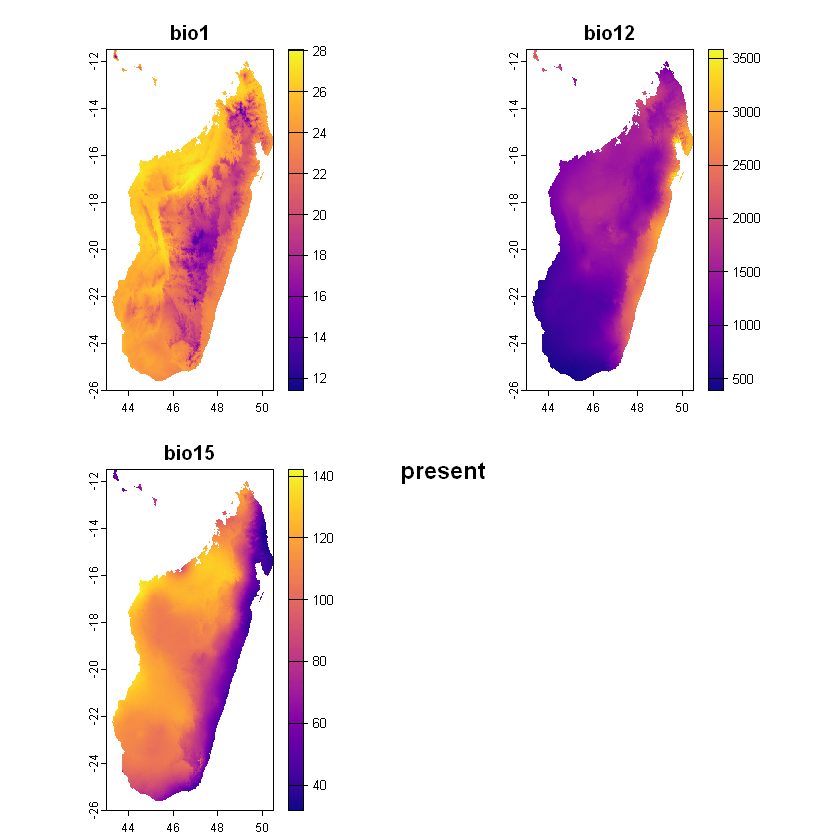

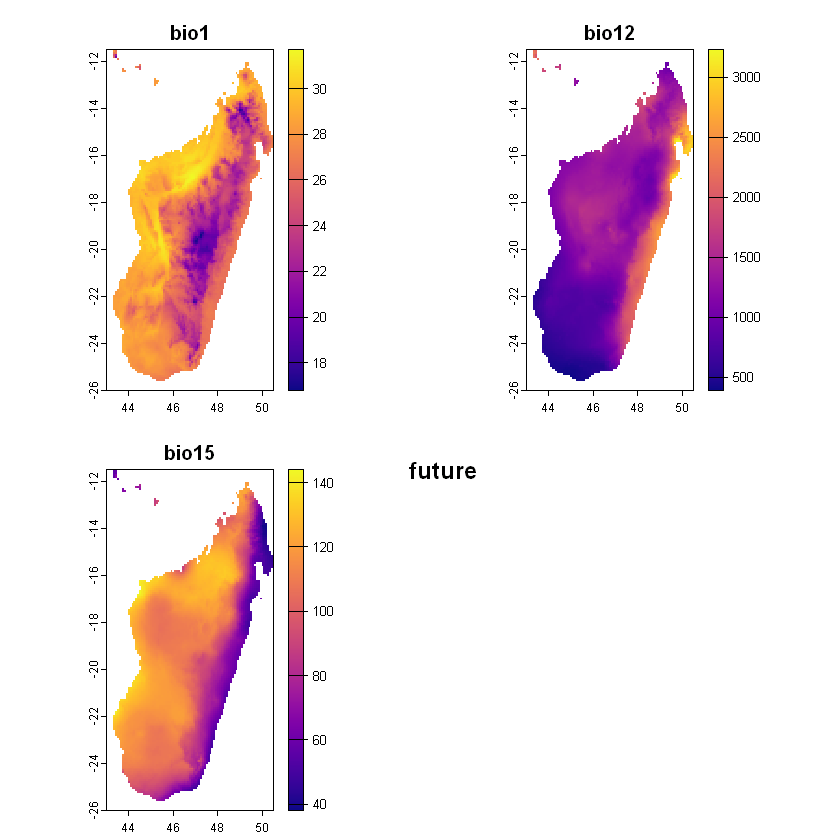

In [8]:
# crop by country
BIO_future <- crop(BIO_future_global, BIO_current)

# select 3 relevant variables
BIO_current_sub <- BIO_current[[c("wc2.1_30s_bio_1", "wc2.1_30s_bio_12", "wc2.1_30s_bio_15")]]
BIO_future_sub  <- BIO_future[[c("bio01", "bio12", "bio15")]]

# rename for simplicity
names(BIO_current_sub) <- names(BIO_future_sub) <- c("bio1", "bio12", "bio15")

# plot
par(mfrow = c(2,1))
plot(BIO_current_sub, col = plasma(500, alpha = 1, begin = 0, end = 1, direction = 1))
title("present")
plot(BIO_future_sub, col = plasma(500, alpha = 1, begin = 0, end = 1, direction = 1))
title("future")

### 2. Create Virtual Species (Response Functions)
Let's create 3 virtual species: each of them has their own response functions to the variables. 

In [7]:
# Each species has a Gaussian response curve to each variable.
# These represent:
# - Species 1: Rainforest specialist
# - Species 2: Dry heat-tolerant
# - Species 3: Highland cold-adapted

curve_list <- list(
  # Species 1: Rainforest specialist (warm, wet, stable)
  formatFunctions(
    bio1  = c(fun = 'dnorm', mean = 25, sd = 3),
    bio12 = c(fun = 'dnorm', mean = 3000, sd = 600),
    bio15 = c(fun = 'dnorm', mean = 60, sd = 15)
  ),
  # Species 2: Dry heat-tolerant (hot, dry, seasonal)
  formatFunctions(
    bio1  = c(fun = 'dnorm', mean = 28, sd = 3),
    bio12 = c(fun = 'dnorm', mean = 600, sd = 300),
    bio15 = c(fun = 'dnorm', mean = 120, sd = 10)
  ),
  # Species 3: Highland cold-adapted (cooler, dry, stable)
  formatFunctions(
    bio1  = c(fun = 'dnorm', mean = 17, sd = 3),
    bio12 = c(fun = 'dnorm', mean = 1000, sd = 400),
    bio15 = c(fun = 'dnorm', mean = 40, sd = 10)
  )
)


### 3. Generate Virtual Species Suitability (Current & Future)
Taking as input the bioclimatic variables we downloaded before and the response functions, `generateSpFromFun` creates the suitability map for each of them in the present and in the future. 

In [6]:
species_current <- list()
species_future  <- list()

for (i in 1:3) {
  species_current[[paste0("species_", i)]] <- generateSpFromFun(
    raster.stack = BIO_current_sub,
    parameters = curve_list[[i]],
    rescale = FALSE
  )
  species_future[[paste0("species_", i)]] <- generateSpFromFun(
    raster.stack = BIO_future_sub,
    parameters = curve_list[[i]],
    rescale = FALSE
  )
}

Generating virtual species environmental suitability...


 - The response to each variable was rescaled between 0 and 1. To
            disable, set argument rescale.each.response = FALSE


Generating virtual species environmental suitability...


 - The response to each variable was rescaled between 0 and 1. To
            disable, set argument rescale.each.response = FALSE


Generating virtual species environmental suitability...


 - The response to each variable was rescaled between 0 and 1. To
            disable, set argument rescale.each.response = FALSE


Generating virtual species environmental suitability...


 - The response to each variable was rescaled between 0 and 1. To
            disable, set argument rescale.each.response = FALSE


Generating virtual species environmental suitability...


 - The response to each variable was rescaled between 0 and 1. To
            disable, set argument rescale.each.response = FALSE


Generating virtual species environmental suitabili

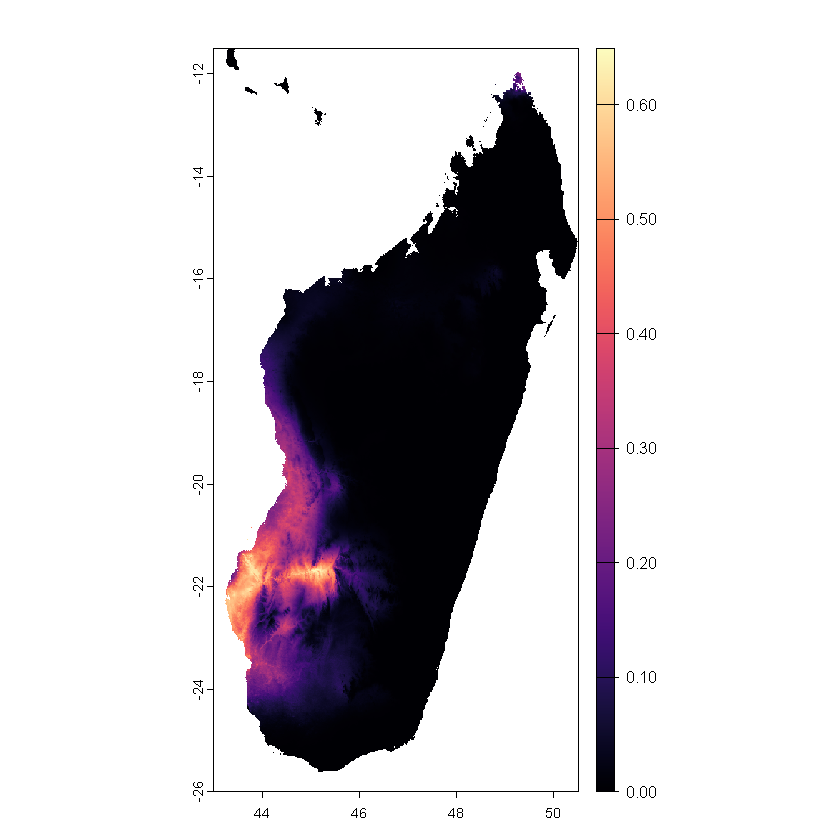

In [9]:
# see suitability map for species 2
plot(species_current$species_2$suitab.raster, col = magma(500, alpha = 1, begin = 0, end = 1, direction = 1))

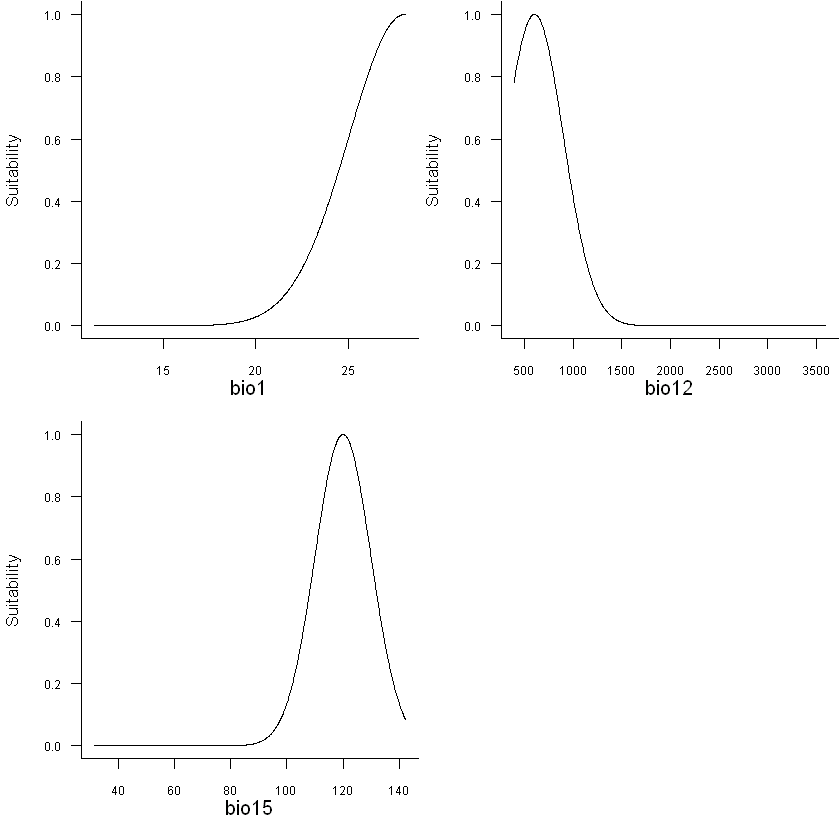

In [10]:
# see response functions for species 2
plotResponse(species_current$species_2)

### 4. Create Regular Grid Over Madagascar 
The final goal of the tutorial is to have all the information about the suitability
of the species and their changes in time in one, well-organized object that will
be a data cube. 

Even if data cubes can have several dimensions, we will set
only 3 dimensions: time, space as cells and species. The attribute, i.e. the
characteristic of which we want to observe changes, is suitability.

So, starting from now, we will go through a process of reduction and aggregation.
The first step is creating a grid over Madagascar to move from 2
dimensions (x and y) to one (polygons).

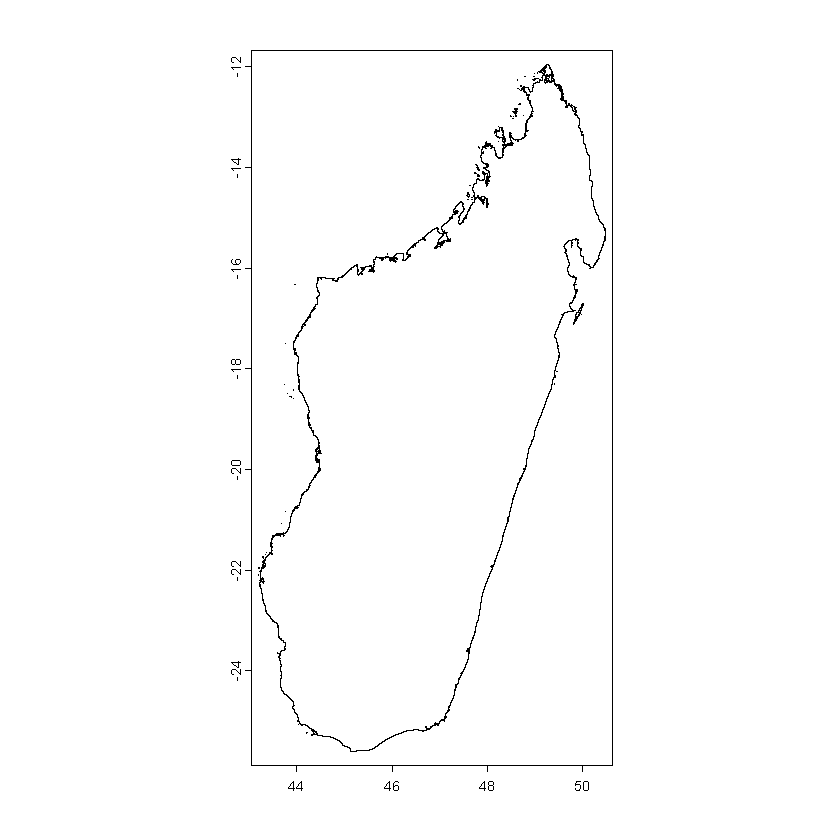

In [11]:
# download Madagascar shapefile
madagascar_shape <- gadm("Madagascar", level = 0, path = tempdir())
plot(madagascar_shape)

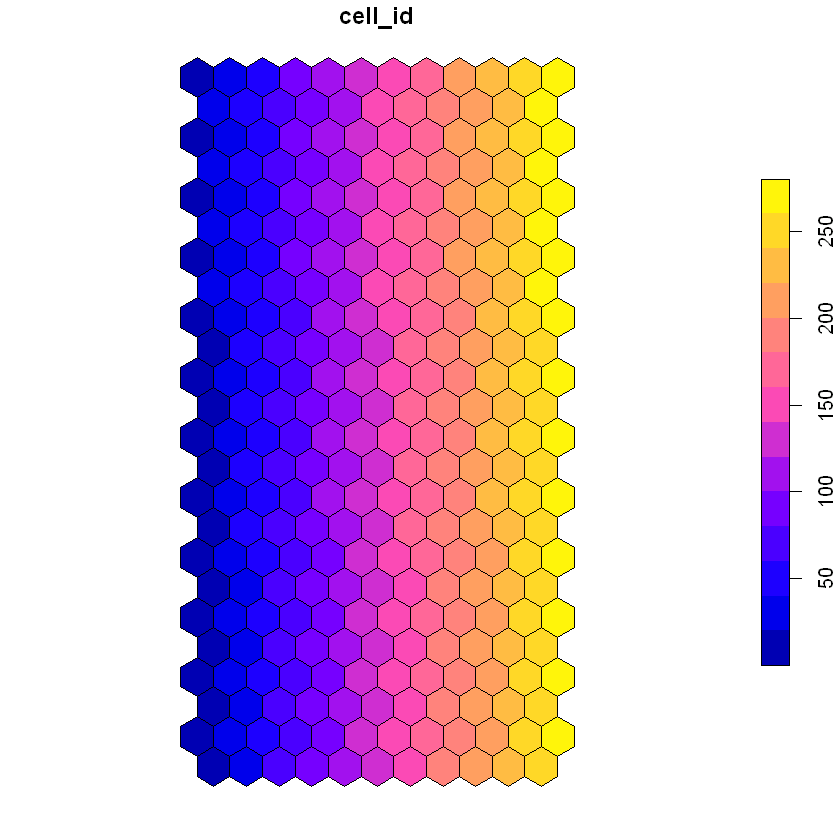

In [12]:
# Create a hexagonal grid with 0.9° spacing
mad_grid <- st_make_grid(
  madagascar_shape,
  cellsize = 0.7,
  what = "polygons",
  square = FALSE
) %>%
  st_as_sf() %>%
  mutate(cell_id = 1:n())

plot(mad_grid)

### 5. Aggregate Suitability Over Spatial Grid 

In the next step, we will turn each suitability layer into a stars object, obtaining 6 data cubes: this way, each suitability layer is a small data cube with 2
dimensions (x and y) and 1 attribute (suitability).

We will then aggregate by mean function each data cube over the grid, further reducing the dimension of the cubes (x and y into cells).

In [13]:
# this may take some time
suitability_aggregated <- list()

for (i in 1:3) {
  sp <- paste0("species_", i)
  
  # convert terra raster to stars object
  r_2020 <- st_as_stars(species_current[[sp]]$suitab.raster)
  r_2070 <- st_as_stars(species_future[[sp]]$suitab.raster)
  
  # aggregate mean suitability over each cell of the grid
  suitability_aggregated[[paste0(sp, "_2020")]] <- aggregate(r_2020, mad_grid, FUN = mean, na.rm = TRUE)
  suitability_aggregated[[paste0(sp, "_2070")]] <- aggregate(r_2070, mad_grid, FUN = mean, na.rm = TRUE)
}


In [ ]:
# suitability_aggregated contains the suitability of each species in the two different periods, as a stars data cube
# let's explore the structure
suitability_aggregated$species_2_2020

stars object with 1 dimensions and 1 attribute
attribute(s):
                         Min.      1st Qu.      Median       Mean    3rd Qu.
VSP suitability  7.988375e-28 1.939147e-06 0.002232834 0.05418982 0.03524554
                      Max. NA's
VSP suitability  0.4951997  115
dimension(s):
  from  to refsys point
x    1 276 WGS 84 FALSE
                                                         values
x POLYGON ((42.83819 -25.40...,...,POLYGON ((50.53819 -12.06...

### 6. Build Suitability Data Cube (stars)
Now that we have the suitability aggregated over polygons, we recombine into two data cubes (present and future). 

Finally, species dimension and time dimension are set. We have one object that contains everything we need to explore suitability changes in community. 

In [15]:
# combine species into stars objects for each time period
current_cube <- c(
  suitability_aggregated$species_1_2020,
  suitability_aggregated$species_2_2020,
  suitability_aggregated$species_3_2020
)

future_cube <- c(
  suitability_aggregated$species_1_2070,
  suitability_aggregated$species_2_2070,
  suitability_aggregated$species_3_2070
)

In [16]:
# see future_cube structure: there are 3 attributes (suitability of the 3 species)
# but they are the same measure! 
future_cube

stars object with 1 dimensions and 3 attributes
attribute(s):
                           Min.      1st Qu.       Median         Mean
VSP.suitability    7.841103e-10 1.474367e-06 5.418260e-05 6.552767e-02
VSP.suitability.1  7.592805e-24 1.387643e-04 1.753991e-02 1.215731e-01
VSP.suitability.2  8.882696e-27 3.595987e-16 9.307226e-12 2.792953e-05
                        3rd Qu.        Max. NA's
VSP.suitability    1.461831e-02 0.713734752  119
VSP.suitability.1  1.184369e-01 0.901775936  119
VSP.suitability.2  5.632142e-06 0.001824748  119
dimension(s):
  from  to refsys point
x    1 276 WGS 84 FALSE
                                                         values
x POLYGON ((42.83819 -25.40...,...,POLYGON ((50.53819 -12.06...

In [17]:
# Add "species" dimension
current_cube <- st_redimension(current_cube) %>%
  st_set_dimensions(2, values = paste0("species_", 1:3), names = "species")

future_cube <- st_redimension(future_cube) %>%
  st_set_dimensions(2, values = paste0("species_", 1:3), names = "species")


In [18]:
# see future_cube structure now: there is one dimension more (species)
future_cube

stars object with 2 dimensions and 1 attribute
attribute(s):
                                        Min.      1st Qu.       Median
VSP.suitability.VSP.suitabi...  8.882696e-27 1.739452e-09 1.753699e-05
                                      Mean    3rd Qu.      Max. NA's
VSP.suitability.VSP.suitabi...  0.06237623 0.01644145 0.9017759  357
dimension(s):
        from  to refsys point
x          1 276 WGS 84 FALSE
species    1   3     NA    NA
                                                               values
x       POLYGON ((42.83819 -25.40...,...,POLYGON ((50.53819 -12.06...
species                               species_1, species_2, species_3

In [27]:
# Combine along the time dimension: we want only one object
suitability_cube <- c(current_cube, future_cube, along = list(time = c(2020, 2070)))

# Set final dimension names
suitability_cube <- st_set_dimensions(suitability_cube, 1, names = "cell")
names(suitability_cube) <- "suitability"

### 7. Explore and Visualize the Data Cube
 We have one object that contains everything we need to explore suitability changes in community. 

In [28]:
# see data cube structure 
print(suitability_cube)

stars object with 3 dimensions and 1 attribute
attribute(s):
                     Min.    1st Qu.       Median       Mean     3rd Qu.
suitability  7.988375e-28 4.8519e-09 3.230392e-05 0.05253489 0.008742386
                  Max. NA's
suitability  0.9017759  702
dimension(s):
        from  to offset delta refsys point
cell       1 276     NA    NA WGS 84 FALSE
species    1   3     NA    NA     NA    NA
time       1   2   2020    50     NA    NA
                                                               values
cell    POLYGON ((42.83819 -25.40...,...,POLYGON ((50.53819 -12.06...
species                               species_1, species_2, species_3
time                                                             NULL


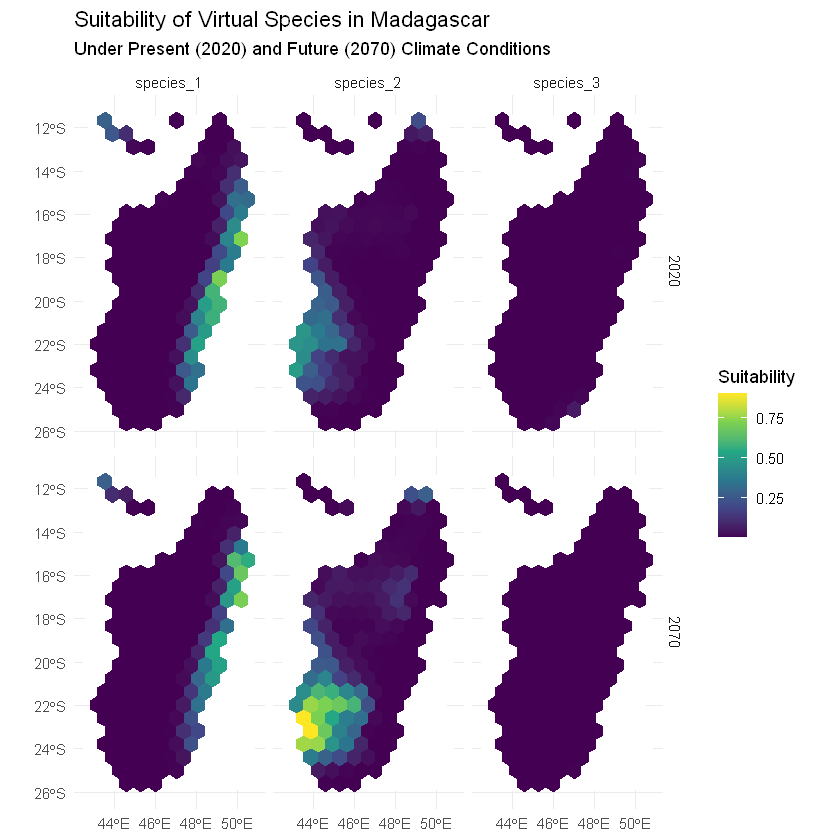

In [21]:
# and plot 
ggplot() +
  geom_stars(data = suitability_cube) +
  facet_grid(time ~ species) +
  scale_fill_viridis_c(name = "Suitability", na.value = "white") +
  theme_minimal() +
  labs(title = "Suitability of Virtual Species in Madagascar",
       subtitle = "Under Present (2020) and Future (2070) Climate Conditions")

### 8. Extracting and Visualizing Suitability for a Specific Location

In this final section, we demonstrate how to extract the suitability values for a specific point in Madagascar for all three species, both for the present (2020) and the future (2070), and visualize these changes.

Let's use coordinates from a real location in Madagascar (e.g., from Google Maps).


In [22]:
# define the point (longitude, latitude)
my_point <- st_sfc(st_point(c(45.98557, -19.43847)), crs = 4326) |> st_sf()

# identify the grid cell in which the point falls
selected_cell <- mad_grid[st_intersects(my_point, mad_grid, sparse = FALSE), ]

# Get the index of the selected cell
idx <- selected_cell$cell_id
print(idx)


[1] 114


In [23]:
# Extract the suitability values from the data cube for that cell
vals <- pull(suitability_cube[,idx,,], "suitability")
print(vals)

, , 1

             [,1]        [,2]         [,3]
[1,] 0.0002105754 0.003326983 2.345402e-11

, , 2

             [,1]       [,2]         [,3]
[1,] 7.675905e-05 0.01879034 8.055089e-14



In [24]:
vals_num <- as.numeric(vals)

# Create a tidy table with species, time, and suitability values
suit_df <- tibble(
  species = rep(paste0("species_", 1:3), times = 2),
  time = rep(c("2020", "2070"), each = 3),
  suitability = vals_num
)

print(suit_df)


# A tibble: 6 x 3
  species   time  suitability
  <chr>     <chr>       <dbl>
1 species_1 2020     2.11e- 4
2 species_2 2020     3.33e- 3
3 species_3 2020     2.35e-11
4 species_1 2070     7.68e- 5
5 species_2 2070     1.88e- 2
6 species_3 2070     8.06e-14


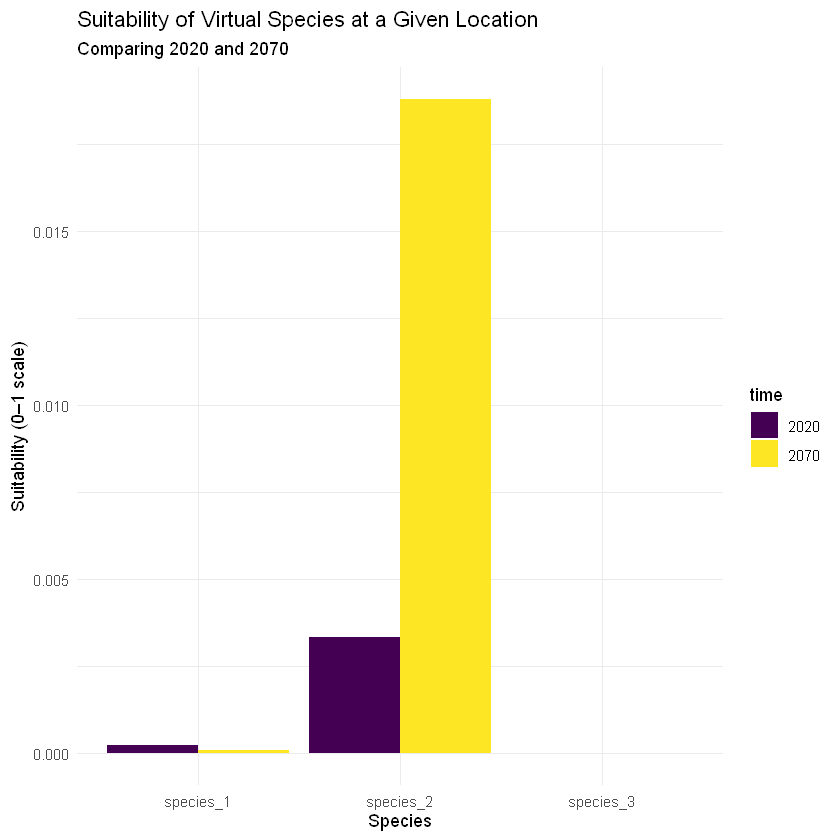

In [25]:
# plot suitability values (barplot)
ggplot(suit_df, aes(x = species, y = suitability, fill = time)) +
  geom_col(position = "dodge") +
  scale_fill_viridis_d() +
  labs(
    title = "Suitability of Virtual Species at a Given Location",
    subtitle = "Comparing 2020 and 2070",
    x = "Species",
    y = "Suitability (0–1 scale)"
  ) +
  theme_minimal()


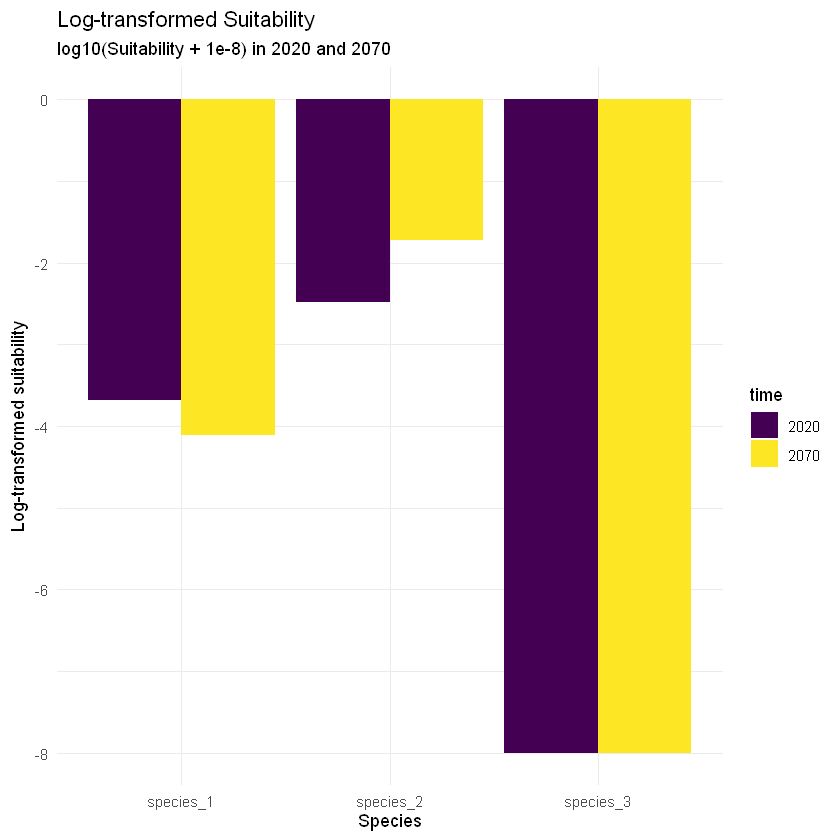

In [26]:
# If values are close to zero and hard to interpret, we can log-transform them:
suit_df$log_suitability <- log10(suit_df$suitability + 1e-8)

ggplot(suit_df, aes(x = species, y = log_suitability, fill = time)) +
  geom_col(position = "dodge") +
  scale_fill_viridis_d() +
  labs(
    title = "Log-transformed Suitability",
    subtitle = "log10(Suitability + 1e-8) in 2020 and 2070",
    y = "Log-transformed suitability",
    x = "Species"
  ) +
  theme_minimal()
